In [2]:
import sys
import pandas as pd

from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import *
plotose = False
import pickle

import lib as lb
import storage as st
import tools as tools
#from tools import *

import os

folderstore = './fconditions/'


In [3]:
sys.argv = ["run", 1.0, -70.0, 0.65, "1000_70_65", 1.0]
len(sys.argv)

6

	0 
	1 
	1 
	1 
	1 
Neuron topology:

|-|       soma(0-1)
   `|       dendA1prox(0-1)
     `|       dendA1(0-1)
       `|       dendShaft(0-1)
         `|       dendA2(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0
Baseline experiment.....................


/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


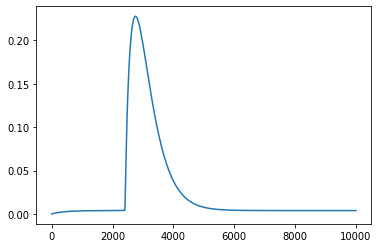

In [4]:


# changing parameters
try:
    assert len(sys.argv)==5, 'No correct number of arguments'
    from bootstrap_unshr import *
    from data_Fullset import SCxL23 as exppar
    #print('No shrinkage correction')
    shflag = ''
except:
    assert len(sys.argv)==6, 'No correct number of arguments'
    shrinkage = float(sys.argv[5])
    if shrinkage > 0.0:
        from bootstrap_shcr import *
        from data_Fullset import SCxL23_shcr as exppar
        #print('We correct shrinkage')
        shflag = 'sh'
    else:
        from bootstrap_unshr import *
        from data_Fullset import SCxL23 as exppar
        #print('No shrinkage correction')
        shflag = ''

exppar.gtrG = exppar.gtrG*float(sys.argv[1]) # 700 pS
gtrG = exppar.gtrG
gtrA = exppar.gtrA
gtrN = exppar.gtrN
GABAErev = float(sys.argv[2])
#exppar.dendDiam = float(sys.argv[3])

# ~ condition = 'nosh_VC700Ecl80'
condition = sys.argv[4]

#print('Hey!')

# Parameter definitions
# Data is stored here
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("ball-2sticks.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="dendShaft",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="dendShaft",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="dendA2",locus=3,L=10.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
#model.comp['B1'].L = 200
#model.comp['B1'].diam = 10
#print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Neuron topology:")
print(lb.h.topology())


# ### Bootstrapping spines and synapses
#
#

# In[2]:


nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']#*2
sis['Rneck'] = sis['Rneck']#*2
sps['Rneck'] = sps['Rneck']#*2

iPSDsh = btShInh(size=nsp)


sp = model.spne[0]
sp.L = dis["L"].mean()
sp.diam = dis["D"].mean()

#print("Area Volume Ah Vh")
#print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])


# ### Excitatory synapse
#
# We need to define the arrival time and dynamics. These parameters may be modified later

# In[4]:


model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = exppar.AMPAtaus[0]
tau2 = exppar.AMPAtaus[1]
AMPA.tau1 = tau1
AMPA.tau2 = tau2

gmax = gtrA*sps['A1'].mean()
stimE=lb.h.NetStim();stimE.number = 1;
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
gmaxN = gtrN*sps['A1'].mean()
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = exppar.NMDAtaus[0]
NMDA.tau2 = exppar.NMDAtaus[1]


# ### Inhibitory synapse

# In[5]:


gmaxG = gtrG*dis['A2'].mean()
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]],
                            spne=True, gmax=gmaxG,
                            tau1=exppar.GABAtaus[0],
                            tau2=exppar.GABAtaus[1],
                            rev = GABAErev)


inhOutside = exppar.inhOutside
if inhOutside:
    gmaxG = gtrG*iPSDsh.mean()
    GABA2, NCG2 = lb.add_GABAsynscomp(model,
                                      model.comp['dendShaft'],
                                      loc = 0.1,
                                      gmax=gmaxG,
                                      tau1=exppar.GABAtaus[0],
                                      tau2=exppar.GABAtaus[1],
                                      rev=GABAErev)


# # Recordings

# In[6]:


trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
vRecn = {}
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    vRecn[dend.name()] = vDendRec[-1]
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
caRecn = {}
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica)
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai)
caRecn['sp ica'] = caDendRec[0]
caRecn['sp iNMDA'] = caDendRec[1]
caRecn['sp Ca'] = caDendRec[2]


# In[7]:


vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)


# In[8]:


vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)


# In[9]:


iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]

currentGABA = iRec[1]
iRec.append(lb.h.Vector())
currentNMDA = iRec[-1]
currentNMDA.record(NMDA._ref_i)


# In[10]:


currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)


# In[11]:


iRec.append(lb.h.Vector())
currentGABA2 = iRec[-1]
currentGABA2.record(GABA2._ref_i)


# ## Small tuning parameters for dendrite?

# In[12]:


dendsizeL0 = exppar.dendsizeL0
dendsizeL = max(max(max(dis['Dss'])+5,max(sis['Dss'])+5),150)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.comp['dendA1prox']
dend.L = exppar.dendsizeL0
dend.diam = exppar.denddiam0


# In[13]:


dendA2 = model.comp['dendA2']
dendA1 = model.comp['dendA1']
dendsh = model.comp['dendShaft']

dendA2.L = 1.0


# In[14]:


dendsh.diam = exppar.dendDiam
dendA1.diam = exppar.dendDiam
dendA2.diam = exppar.dendDiam


# In[15]:


model.RM = exppar.rm
for sec in lb.h.allsec():
    sec.Ra = exppar.ra
    sec.cm = 1.0
    sec.g_pas = 1.0/model.RM

factor = exppar.factor2nddend
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = exppar.len2nddend
model.comp['dendB1'].diam = 1


# In[16]:


rhosp = 1.3
diamneck = sps['meanDneck'].mean()/1e3
dendareaperL = rhosp*(mean(sps['Ah'])+(pi*diamneck))
factor = dendareaperL/(pi*dendA1.diam)
#print(factor)
factorsp = factor
factordd = (pi*dendA1.diam-(pi*diamneck**2/4.0)*rhosp)/(pi*dendA1.diam)
#print(factordd,factordd+factorsp)

factor = factordd+factorsp
factor = exppar.factorspinesdend
dendA2.cm = factor
dendA1.cm = factor

dendA2.g_pas = factor/model.RM
dendA1.g_pas = factor/model.RM


# In[17]:


dendA1.nseg = int(dendA1.L//10)+1
dendA2.nseg = int(dendA2.L//10)+1

dendA1.nseg = 10
dendA2.nseg = 10
#print(dendA1.nseg,dendA2.nseg)


# In[18]:


lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)


# In[19]:


Rdendprox = model.comp['dendA1prox'].L*1e-6/2.0*model.comp['dendA1prox'].Ra/100/(pi*(model.comp['dendA1prox'].diam*1e-6/2.0)**2)
diam0 = 0.15

def simulateSet(model,spn,tG = 500,ton = 50,
                toffset = 50,t_stop = 250, EL = -65,
                btsr = None,VDCC = array([0.,0,0,0]),
                dendrec = True,inhOutside= False, iPSDsh = None):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.comp['dendShaft']
    dendA1 = model.comp['dendA1']
    dendA2 = model.comp['dendA2']
    neck = model.neck[0]
    sp = model.spne[0]

    dshL = dendsh.L
    dendsizeL = dendsh.L+dendA1.L+dendA2.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"], spn["meanDneck"]/1e3))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()

    nsp = data.shape[0]
    if iPSDsh is None:
        iPSDsh = zeros(nsp)
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        NCG2.weight[0] = iPSDsh[i] *gtrG#*0
        #print(NC.weight[0],data[i,0],gtrA)
        if inhOutside:
            NCG.weight[0] = 0.0
        else:
            NCG2.weight[0] = 0.0

        neck.L = data[i,7]
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])

        # neck.diam = data[i,9]
        # Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
        # neck.Ra = data[i,3]*(neck.diam)**2*pi/0.04/neck.L

        posD = data[i,4]

        dendA1.L = posD-dshL/2
        dendA2.L = dendsizeL-posD-dshL/2


        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        sp.g_pas = data[i,8]/model.RM
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2

        #CaTcond = 1e-3# pS
        CaTcond = 1e-4# THis is a factor to transform pS/um^2 to S/cm^2 units of neuron

        freespinearea = (spineArea-data[i,0])/spineArea

        sp.pbar_caL13_alt =freespinearea* VDCC[0]*CaTcond#/spineArea
        sp.pbar_caL_alt = freespinearea*VDCC[1]*CaTcond#/spineArea
        sp.pbar_can_alt = freespinearea*VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caq_alt = freespinearea*VDCC[3]*CaTcond#/spineArea
        #sp.pcarbar_car_alt = VDCC[4]*CaTcond


        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50
        NCG2.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendA1.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendA1(f)._ref_v)
            else:
                vDendEL[il].record(dendA1(0.0)._ref_v)

        for il in range(10):
            f = 7.5*il/dendA2.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendA2(f)._ref_v)
            else:
                vDendEL2[il].record(dendA2(1.0)._ref_v)

        lb.h.finitialize(model.E_PAS)


        lb.neuron.run(t_stop)


        current = abs((array(vDendRec[0])-array(vrec[0]))/Rdendprox)

        vtracs[:,i] = array(vspneRec[0])
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])

        vtracsS[:,i] = array(vrec)

        vavg[:,0] += array(vspneRec[0])
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1])
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec)
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1

        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0]
        if inhOutside:
            aG = abs(array(currentGABA2)).argmax()
            maxGABA = array(currentGABA2)[aG]
        else:
            aG = abs(array(currentGABA)).argmax()
            maxGABA = array(currentGABA)[aG]


        #aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        aN = abs(array(currentNMDA)).argmax()

        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,
                    max(vDendRec[3])-EL,max(vrec)-EL,
                    max(cat)-cat[0],maxGABA,
                    array(currentAMPA)[aA],max(abs(current)),
                    array(currentNMDA)[aN]]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break

    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,
           Ctracs,me2,me3,array(trec))


# In[20]:


# In pS/um^2 we change it inside

VDCCa =  array([25., 25., 20., 20., 20.])
# VDCCa =  array([70., 70., 60., 60., 60.])

EL0 = -70
# It has to be provided as S/cm^2 -> pS/um^2 = pS/(1e-8 cm^2)=1e-4 S/cm^2


# In[22]:




# # Baseline conditions

# In[23]:


with open(datasetfile,"rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
# print(spdata['A1'].shape)
spdata['A2'][isnan(spdata['A2'])] = 0.0
#spdata['Rneck'] = spdata['Rneck']
# print(spdata['A2'].shape)

sel = ones(spdata['A2'].shape[0]) == 1
keys = list(spdata.keys())
# print(keys)
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)
keys.pop(9)
keys.pop(3)
#print(keys)

for key in keys:
    sel = sel*isfinite(spdata[key])
    #print(key, isfinite(spdata[key]).sum())
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    #print(key,':',isfinite(spdata[key]).sum())
dendsizeL = max(max(spdata['Dss'])+5,150)
# print(spdata['A1'].shape)


# In[29]:

spdata['Rmorph'] = spdata['Rneck'].copy()
spdata['Rneck'] = spdata['Rmorph']*2.5


# In[30]:

tools.showmessage("Baseline experiment")

td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,
                  toffset = 70,t_stop = 500,
                  EL = EL0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False)

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
mes
mes.shape
plt.plot(Ctracs[:,0])

In [5]:
mes0 = mes.copy()
Ctracs0 = Ctracs.copy()

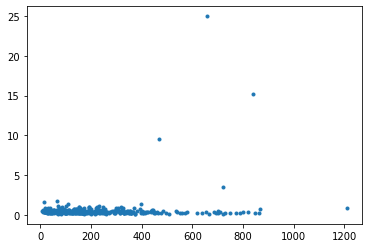

In [6]:
plt.plot(mes[:,0],mes[:,4],'.')

run:503: RuntimeWarning: invalid value encountered in sqrt
run:504: RuntimeWarning: invalid value encountered in sqrt


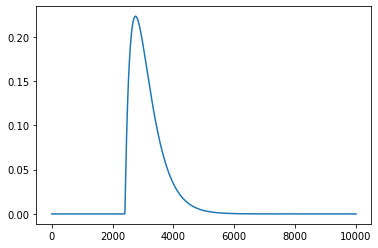

In [7]:
VDCCa =  array([25., 25., 20., 20., 20.])

res = simulateSet(model,spdata,tG = td,ton = 50,
                  toffset = 70,t_stop = 500,
                  EL = EL0,btsr = ones(9)==1,
                  VDCC = VDCCa*0,dendrec=False)

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,trec = res
mes
mes.shape
plt.plot(Ctracs[:,0])

Text(0.5, 0, 'Total Ca (uM)')

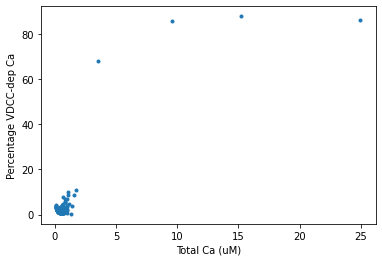

In [8]:
plt.plot(mes0[:,4],100*(1-mes[:,4]/mes0[:,4]),'.')
plt.ylabel("Percentage VDCC-dep Ca")
plt.xlabel("Total Ca (uM)")

Text(0.5, 0, 'Total Ca (uM)')

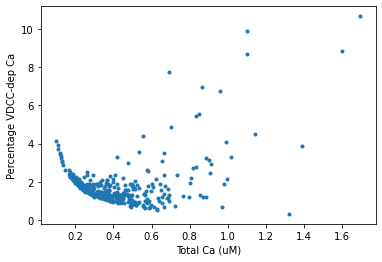

In [9]:
sel = mes0[:,4]<3.
plt.plot(mes0[sel,4],100*(1-mes[sel,4]/mes0[sel,4]),'.')
plt.ylabel("Percentage VDCC-dep Ca")
plt.xlabel("Total Ca (uM)")

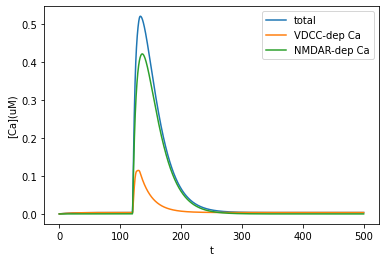

In [10]:
plt.plot(trec,Ctracs0.mean(-1),label = "total")
plt.plot(trec,Ctracs0.mean(-1)-Ctracs.mean(-1), label = "VDCC-dep Ca")
plt.plot(trec,Ctracs.mean(-1), label = "NMDAR-dep Ca")
plt.ylabel("[Ca](uM)")
plt.xlabel("t")
plt.legend()

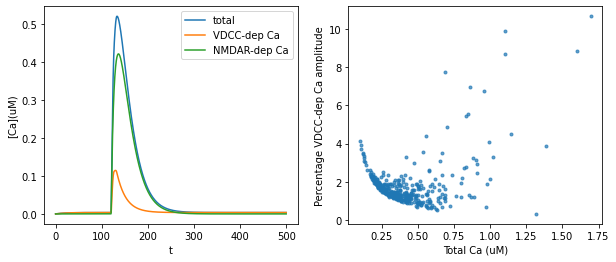

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot(trec,Ctracs0.mean(-1),label = "total")
ax[0].plot(trec,Ctracs0.mean(-1)-Ctracs.mean(-1), label = "VDCC-dep Ca")
ax[0].plot(trec,Ctracs.mean(-1), label = "NMDAR-dep Ca")
ax[0].set_ylabel("[Ca](uM)")
ax[0].set_xlabel("t")
ax[0].legend()
sel = mes0[:,4]<3.
ax[1].plot(mes0[sel,4],100*(1-mes[sel,4]/mes0[sel,4]),'.', alpha = 0.7)
ax[1].set_ylabel("Percentage VDCC-dep Ca amplitude")
ax[1].set_xlabel("Total Ca (uM)")
fig.savefig("fconditions/resub/casources_amplitude.png", dpi = 300)

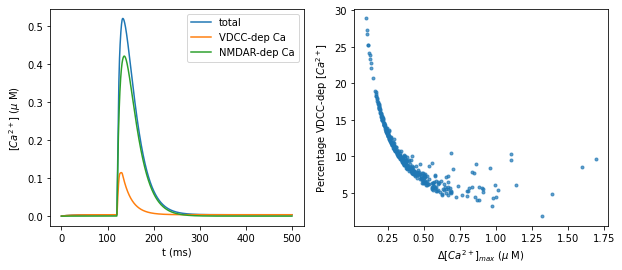

In [15]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot(trec,Ctracs0.mean(-1),label = "total")
ax[0].plot(trec,Ctracs0.mean(-1)-Ctracs.mean(-1), label = "VDCC-dep Ca")
ax[0].plot(trec,Ctracs.mean(-1), label = "NMDAR-dep Ca")
ax[0].set_ylabel("$[Ca^{2+}]$ ($\mu$ M) ")
ax[0].set_xlabel("t (ms)")
ax[0].legend()

sel = mes0[:,4]<3.
ax[1].plot(mes0[sel,4],100*(1-Ctracs.sum(0)/Ctracs0.sum(0))[sel],'.', alpha = 0.7)
ax[1].set_ylabel("Percentage VDCC-dep $[Ca^{2+}]$")
ax[1].set_xlabel("$\Delta [Ca^{2+}]_{max}$ ($\mu$ M)")
fig.savefig("fconditions/resub/casources.png", dpi = 300)
fig.savefig("fconditions/resub/casources.pdf", dpi = 300)


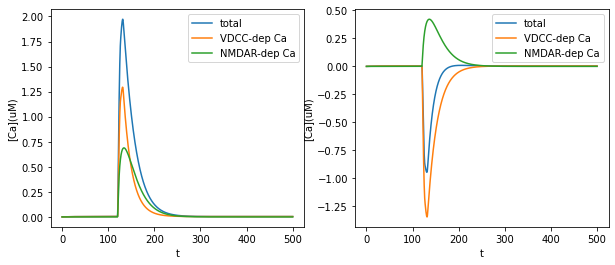

In [62]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot(trec,Ctracs0.mean(-1)+Ctracs0.std(-1),label = "total")
ax[0].plot(trec,Ctracs0.mean(-1)+Ctracs0.std(-1)-Ctracs.mean(-1)-Ctracs.std(-1), label = "VDCC-dep Ca")
ax[0].plot(trec,Ctracs.mean(-1)+Ctracs.std(-1), label = "NMDAR-dep Ca")
ax[0].set_ylabel("[Ca](uM)")
ax[0].set_xlabel("t")
ax[0].legend()
ax[1].plot(trec,Ctracs0.mean(-1)-Ctracs0.std(-1),label = "total")
ax[1].plot(trec,Ctracs0.mean(-1)-Ctracs0.std(-1)-Ctracs.mean(-1), label = "VDCC-dep Ca")
ax[1].plot(trec,Ctracs.mean(-1), label = "NMDAR-dep Ca")
ax[1].set_ylabel("[Ca](uM)")
ax[1].set_xlabel("t")
ax[1].legend()

In [52]:
def plot_shades(data,t,ax=None,c='C0',band= None,label= None,linestyle='-'):
    if ax is None:
        ax = gca()
    vtracso = data*1.0
    vtracso.sort(axis=1)
    sh = vtracso.shape[1]
    nmed = sh//2
    nl1, nv1 = int(sh*0.16),int(sh*(1-0.16))
    nl2, nv2 = int(sh*0.025),int(sh*(1-0.025))

    if band == 0:
        pass
    elif band == 1:
        ax.plot(t,vtracso[:,nv1],color=c,alpha=0.5)
        ax.plot(t,vtracso[:,nl1],color=c,alpha=0.5)
    elif band ==2:
        ax.plot(t,vtracso[:,nl2],vtracso[:,nv2],color=c,alpha=0.3)
    else:
        ax.plot(t,vtracso[:,nl1],vtracso[:,nv2],color=c,alpha=0.3)
        ax.plot(t,vtracso[:,nl1],vtracso[:,nv1],color=c,alpha=0.3)
    return(ax)


In [53]:
def plot_intervals(x,y,label, color = "C0"):
    plt.plot(x,y.mean(-1),label = label)
    plot_shades(y, x, band = 1,c=color, label=label)

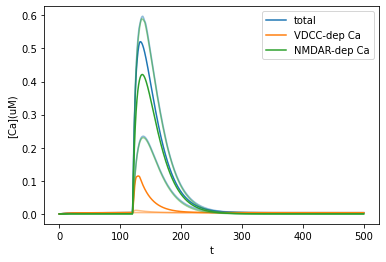

In [54]:
plot_intervals(trec,Ctracs0, color = "C0", label = "total")
plot_intervals(trec,Ctracs0-Ctracs, color="C1",label = "VDCC-dep Ca")
plot_intervals(trec,Ctracs, color="C2", label = "NMDAR-dep Ca")
plt.ylabel("[Ca](uM)")
plt.xlabel("t")
plt.legend()